In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
MODEL_NAME = "my_model"
DATA_DIR = os.path.join(os.getcwd(), r'TensorFlow\workspace\training')
MODELS_DIR = os.path.join(DATA_DIR, 'exported-models')
PATH_TO_CFG = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'pipeline.config'))
PATH_TO_CKPT = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'checkpoint/'))
LABEL_FILENAME = 'label_map.pbtxt'
PATH_TO_LABELS = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, LABEL_FILENAME))

In [3]:
# Prevent GPU complete consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)]
        )
    except RuntimeError as e:
        print(e)

In [4]:
tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# # Enable GPU dynamic memory allocation
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

In [5]:

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

### Webcam Detection

In [5]:
import numpy as np

import cv2

cap = cv2.VideoCapture(0)


while True:
    # Read frame from camera
    ret, image_np = cap.read()

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # Display output
    cv2.imshow('object detection', cv2.resize(image_np_with_detections, (800, 600)))

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

ValueError: in user code:

    File "C:\Users\thela\AppData\Local\Temp\ipykernel_22752\3811838702.py", line 21, in detect_fn  *
        image, shapes = detection_model.preprocess(image)
    File "c:\Users\thela\Documents\UAB\TFG\3-SegonProgres\CustomOCR\venv\lib\site-packages\object_detection\meta_architectures\ssd_meta_arch.py", line 484, in preprocess  *
        normalized_inputs, self._image_resizer_fn)
    File "c:\Users\thela\Documents\UAB\TFG\3-SegonProgres\CustomOCR\venv\lib\site-packages\object_detection\utils\shape_utils.py", line 492, in resize_images_and_return_shapes  *
        outputs = static_or_dynamic_map_fn(
    File "c:\Users\thela\Documents\UAB\TFG\3-SegonProgres\CustomOCR\venv\lib\site-packages\object_detection\utils\shape_utils.py", line 246, in static_or_dynamic_map_fn  *
        outputs = [fn(arg) for arg in tf.unstack(elems)]
    File "c:\Users\thela\Documents\UAB\TFG\3-SegonProgres\CustomOCR\venv\lib\site-packages\object_detection\core\preprocessor.py", line 3327, in resize_image  *
        new_image = tf.image.resize_images(

    ValueError: 'images' must have either 3 or 4 dimensions.


### Images Detection

In [6]:
IMAGE_PATHS = os.path.join(DATA_DIR, 'test-images')

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

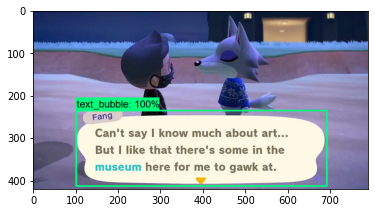

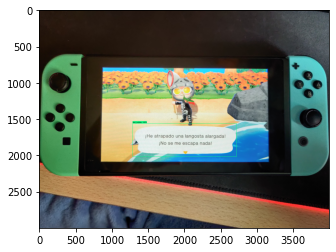

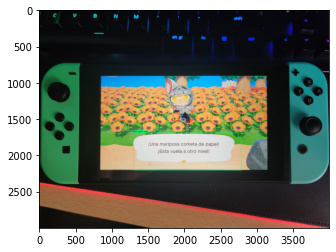

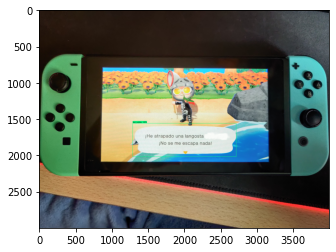

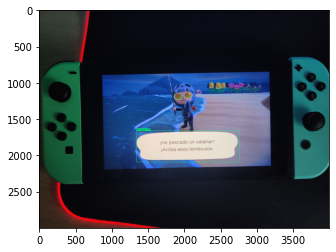

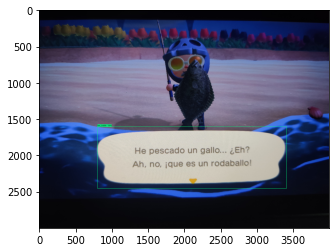

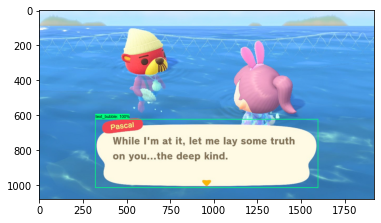

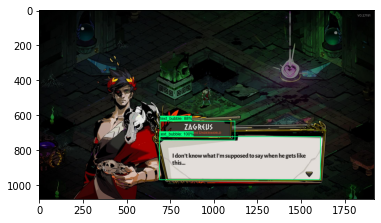

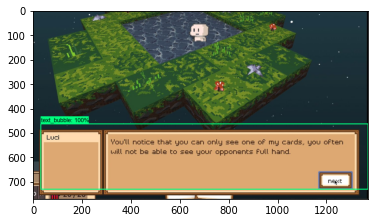

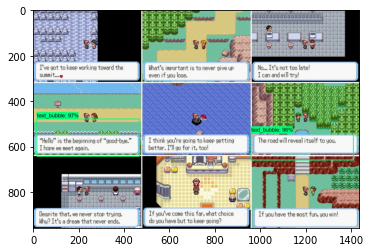

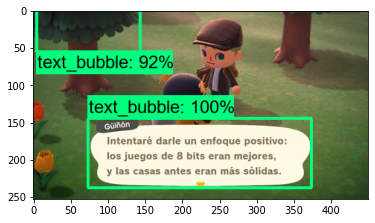

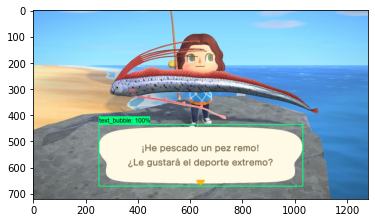

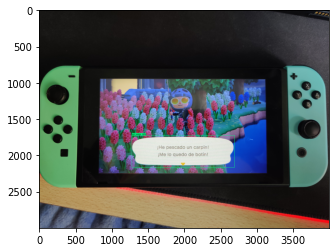

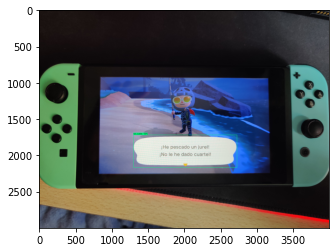

In [83]:
IMAGE_PATH = os.path.join(DATA_DIR, 'test-images')

for image_path in os.listdir(IMAGE_PATH):
    img = cv2.imread(os.path.join(IMAGE_PATH, image_path))
    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections[0].pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections[0].items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

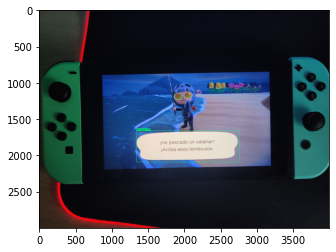

In [97]:
IMAGE_PATH = os.path.join(DATA_DIR, 'test-images', 'test_13.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections[0].pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections[0].items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

### OCR

In [60]:
fish_list = ['carpín',
'pez dorado',
'amarguillo',
'cacho',
'leucisco',
'carpa',
'koi',
'pez telescopio',
'killi',
'cangrejo de río',
'tortuga caparazón blando',
'renacuajo',
'rana',
'gobio de río',
'locha',
'siluro',
'pez cabeza de serpiente',
'pez sol',
'perca amarilla',
'perca',
'lucio',
'eperlano',
'ayu',
'salmón japonés',
'trucha',
'taimén',
'salmón',
'salmón real',
'cangrejo de Shanghái',
'gupi',
'pez doctor',
'pez ángel',
'tetra neón',
'piraña',
'arowana',
'dorado',
'pez caimán',
'pirarucú',
'bichir ensillado',
'mariposa marina',
'caballito de mar',
'pez payaso',
'pez cirujano',
'pez mariposa',
'pez napoleón',
'pez león',
'pez globo',
'pez erizo',
'jurel',
'dorada japonesa',
'lubina',
'pargo rojo',
'gallo',
'rodaballo',
'calamar',
'morena',
'anguila de listón azul',
'pez balón',
'atún',
'pez espada',
'jurel gigante',
'raya',
'pez luna',
'pez martillo',
'tiburón',
'pez sierra',
'tiburón ballena',
'pez remo',
'celacanto',
'esturión',
'tilapia',
'betta',
'tortuga mordedora',
'trucha dorada',
'pez arcoíris',
'boquerón',
'lampuga',
'rémora',
'pez cabeza transparente',
'ranchú']


insect_list = ['cigarra marrón',
'mariposa tigre',
'mariposa alas de Brooke',
'libélula roja',
'mariposa alas de pájaro',
'zapatero',
'hormiga',
'cochinilla',
'cochinilla de arena',
'polilla',
'escarabajo nadador',
'libélula caballito del diablo',
'goliat',
'mosca',
'mantis orquídea',
'escarabajo tigre',
'escarabajo astado hércules',
'cigarrilla',
'esc. ciervo cyclommatus',
'luciérnaga',
'escarabajo pelotero',
'langosta',
'mosquito',
'mantis religiosa',
'chinche',
'longicornio asiático',
'mariposa bianor',
'caracol',
'escarabajo astado japonés',
'saltamontes',
'escarabajo geotrúpido',
'escarabajo astado atlas',
'insecto hoja',
'grillo común',
'cigarra gigante',
'araña',
'mariposa narciso',
'cigarra oriental',
'oruga de bolsón',
'abeja melífera',
'escarabajo ciervo Miyama',
'mariposa colias',
'mariposa común',
'mariposa celeste',
'ciempiés',
'insecto palo',
'escarabajo ciervo arcoíris',
'escarabajo ciervo sierra',
'pulga',
'grillo cebollero',
'libélula tigre',
'mariposa monarca',
'escarabajo ciervo gigante',
'escarabajo ciervo tornasol',
'escarabajo oro',
'escorpión',
'muda de cigarra',
'grillo campana',
'avispa',
'langosta alargada',
'escarabajo joya',
'tarántula',
'mariquita',
'langosta migratoria',
'cigarra común',
'escarabajo violín',
'cangrejo ermitaño',
'polilla atlas',
'escarabajo astado elefante',
'mariposa triángulo azul',
'mariposa cometa de papel',
'marip. emperador japonés',
'escarabajo verde japonés',
'escarabajo ciervo jirafa',
'chinche con rostro humano',
'polilla crepuscular',
'gorgojo azul',
'escarabajo rosalia batesi',
'chinche acuática gigante',
'libélula damisela',]

In [98]:
import torch
import easyocr
detection_threshold = 0.7

In [99]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

width = image.shape[1]
height = image.shape[0]

([[311, 115], [1089, 115], [1089, 207], [311, 207]], 'iHe pescado un calamar!', 0.9970632451120485)
([[331, 212], [1059, 212], [1059, 300], [331, 300]], 'iArriba esos tentáculos', 0.9122968601244271)


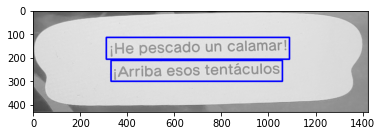

In [100]:
#ROI filtering + OCR
for idx, box in enumerate(boxes):

    # Convert image to grayscale
    image = np.tile(
        np.mean(image, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    roi = box*[height, width, height, width]
    region = image[int(roi[0]):int(roi[2]), int(roi[1]):int(roi[3])]

    reader = easyocr.Reader(['es', 'en'])
    #ocr_result = reader.readtext(region, paragraph=True)
    ocr_result = reader.readtext(region, slope_ths=3, width_ths=5)
    #print(ocr_result)

    for ocr_text in ocr_result:
        print(ocr_text)
        if ocr_text[2]>0.65:
            cv2.rectangle(region, [round(num) for num in ocr_text[0][0]], [round(num) for num in ocr_text[0][2]], (255, 0, 0), 5)
            #cv2.rectangle(region, round(num for ocr_text[0][0]), round(ocr_text[0][2]), (255, 0, 0), 5)

    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    
    plt.show()


#print([ocr_text[1] for ocr_text in ocr_result if ocr_text[2]>0.85])

In [101]:
texto = ' '.join([ocr_text[1] for ocr_text in ocr_result if ocr_text[2]>0.65])
print(texto)
insect_predictions = [insect for insect in insect_list if insect in texto]
fish_predictions = [insect for insect in fish_list if insect in texto]

print(insect_predictions)

if insect_predictions:
    if len(insect_predictions) > 1:
        result =  max(insect_predictions, key=len)
    else:
        result = insect_predictions[0]

        
if fish_predictions:
    if len(fish_predictions) > 1:
        result = max(fish_predictions, key=len)
    else:
        result = fish_predictions[0]

iHe pescado un calamar! iArriba esos tentáculos
[]
['calamar']


In [51]:
boxes = []
for puntos in ocr_result:
    if puntos[2] > 0.65:
        x = round(sum([xs[0] for xs in puntos[0]])/4)
        y = round(sum([ys[1] for ys in puntos[0]])/4)
        boxes.append((puntos[1],(x,y)))
    #print(puntos[1],"x:", x, "y:", y)

print(boxes)

[('iHe pescado un jurel!', (715, 166)), ('le he dado cuartel!', (780, 269)), ('iNo', (414, 268))]


In [37]:
sorted_by_second = sorted(boxes, key=lambda tup: tup[1][1])
print(sorted_by_second)

[('iHe atrapado una langosta alargada!', (727, 176)), ('iNo', (414, 273)), ('se', (522, 276)), ('me escapa nada!', (836, 278))]


In [35]:
lineas = {}
lineas[1]=(boxes[0])
print(lineas)

for item in boxes[1:]:
    if 




{1: ('iHe atrapado una langosta alargada!', (727, 176))}


In [13]:
from difflib import SequenceMatcher

def similar(a,b):
    return SequenceMatcher(None, a, b).ratio()

In [21]:
cabecilla = ' '.join(ocr_result[0][1].strip().split()[:2])
similar(cabecilla, "He pescado")

0.9523809523809523

In [25]:
pescao = ' '.join(ocr_result[0][1].strip().replace("¡","").replace("!","").split()[3:])
print(pescao)

pez remo


In [27]:
a = "pez remo"
similar(a, pescao)

0.9333333333333333